## Modeling

----------------

TO DO!!!!!

Data meets OLS Assumptions.

Correctly fit at least 1 model.

Your model should not include any predictors with p-values greater than .05

Check Model Validity:
- Interpret beta coefficients
- Interpret residuals (are you over/under estimating)
- cross validate with Kfolds
- check predictions
- does this model satisfy the problem?
---------------------

##### Construct model to solve problem:
Model aims to answer price prediction for home features in specific areas (determined by above)

Define the target:
- Target = home sale price. 

Define the predictors:
- What are at least three features that exibit a linear relationship with sale price?

Solve problem:
- Build model to predict sale price based on input of selected features.


#### Model Quality/Approach

* Your model should not include any predictors with p-values greater than .05.  
* Your notebook shows an iterative approach to modeling, and details the parameters and results of the model at each iteration.  
    * **Level Up**: Whenever necessary, you briefly explain the changes made from one iteration to the next, and why you made these choices.  
* You provide at least 1 paragraph explaining your final model.   
* You pick at least 3 coefficients from your final model and explain their impact on the price of a house in this dataset.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# VIF each column against all others, drop very high VIF, recheck

def build_sm_ols(df, features_to_use, target, add_constant=False, show_summary=True):
    X = df[features_to_use]
    if add_constant:
        X = sm.add_constant(X)
    y = df[target]
    ols = sm.OLS(y, X).fit()
    if show_summary:
        print(ols.summary())
    return ols


def check_vif(df, features_to_use, target_feature):
    ols = build_sm_ols(df=df, features_to_use=features_to_use, target=target_feature, show_summary=False)
    r2 = ols.rsquared
    return 1 / (1 - r2)

def check_vif_feature_space(df, features_to_use,vif_threshold=3.0):
    all_good_vif = True
    for feature in features_to_use:
        target_feature = feature
        _features_to_use = [f for f in features_to_use if f!=target_feature]
        vif = check_vif(df=df, features_to_use=_features_to_use, target_feature=target_feature)
        if vif >= vif_threshold:
            print(f"{target_feature} surpassed threshold with vif={vif}")
            all_good_vif = False
    return all_good_vif

def check_model(df, 
                features_to_use, 
                target_col, 
                add_constant=False, 
                show_summary=False, 
                vif_threshold=3.0):
    has_multicollinearity = check_vif_feature_space(df=df, 
                                                    features_to_use=features_to_use, 
                                                    vif_threshold=vif_threshold)
    if not has_multicollinearity:
        print("Model contains multicollinear features")
    
    # build model 
    ols = build_sm_ols(df=df, features_to_use=features_to_use, 
                       target=target_col, add_constant=add_constant, 
                       show_summary=show_summary)
    
    # check residuals
    resids_are_norm = check_residuals_normal(ols)
    resids_are_homo = check_residuals_homoskedasticity(ols)
    
    if not resids_are_norm or not resids_are_homo:
        print("Residuals failed test/tests")
    return ols

# assumptions of ols
# residuals are normally distributed
def check_residuals_normal(ols):
    residuals = ols.resid
    t, p = stats.shapiro(residuals)
    if p <= 0.05:
        return False
    return True


# residuals are homoskedasticitous
def check_residuals_homoskedasticity(ols):
    import statsmodels.stats.api as sms
    resid = ols.resid
    exog = ols.model.exog
    lg, p, f, fp = sms.het_breuschpagan(resid=resid, exog_het=exog)
    if p >= 0.05:
        return True
    return False



In [3]:
df = pd.read_csv("../data/kc_house_data_cleaned.csv").drop('Unnamed: 0', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20287 entries, 0 to 20286
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 20287 non-null  float64
 1   bedrooms              20287 non-null  int64  
 2   bathrooms             20287 non-null  float64
 3   has_basement          20287 non-null  int64  
 4   sqft_living           20287 non-null  int64  
 5   sqft_lot              20287 non-null  int64  
 6   liv/lot               20287 non-null  float64
 7   view                  20287 non-null  float64
 8   age                   20287 non-null  int64  
 9   age_decade            20287 non-null  int64  
 10  condition             20287 non-null  int64  
 11  grade                 20287 non-null  int64  
 12  reno?                 20287 non-null  int64  
 13  reno_age              20287 non-null  float64
 14  lat                   20287 non-null  float64
 15  long               

In [4]:
list(df.columns)

['price',
 'bedrooms',
 'bathrooms',
 'has_basement',
 'sqft_living',
 'sqft_lot',
 'liv/lot',
 'view',
 'age',
 'age_decade',
 'condition',
 'grade',
 'reno?',
 'reno_age',
 'lat',
 'long',
 'zipcode',
 'zipcode_mean_price',
 'zipcode_median_price',
 'zipcode_mode_price',
 'zip_rank_price',
 'zipcode_mean_lot',
 'zipcode_mean_liv',
 'pop_den_by_zip']

In [5]:
# drop columns that used target = 'price' in calculation

df.drop(['zipcode_mean_price',
 'zipcode_median_price',
 'zipcode_mode_price',
 'zip_rank_price'], axis=1, inplace=True)


### Examine Pairwise Correlation Between Features

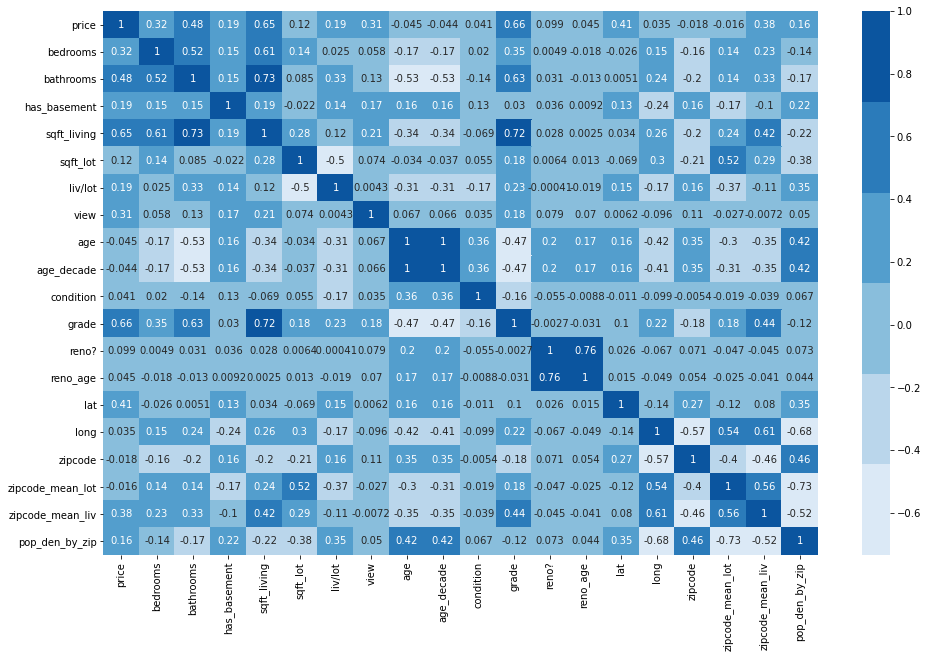

In [6]:
plt.figure(figsize=(16,10))
sns.heatmap(df.corr(), annot=True, cmap=sns.color_palette('Blues'), fmt='0.2g');

Find Top 10 Features Correlated with Target

In [7]:
target = 'price'
correlation_array = []
failed_cols = []
for col in df.drop(target,axis=1).columns:
    try:
        correlation = abs(np.corrcoef(df[col], df[target])[0][1])
        if correlation == correlation:
            correlation_array.append((col, correlation))
        else:
            failed_cols.append(col)
    except:
        failed_cols.append(col)
correlation_array = sorted(correlation_array, key=lambda x: x[1], reverse=True)
correlation_array

[('grade', 0.6564668654869398),
 ('sqft_living', 0.646749268012164),
 ('bathrooms', 0.47561906645975105),
 ('lat', 0.4095919249106659),
 ('zipcode_mean_liv', 0.377472433821231),
 ('bedrooms', 0.31694041550001695),
 ('view', 0.31453759767836975),
 ('liv/lot', 0.19417626720490094),
 ('has_basement', 0.18544003591018562),
 ('pop_den_by_zip', 0.16081874818701875),
 ('sqft_lot', 0.12028729471229478),
 ('reno?', 0.09931368575036985),
 ('age', 0.04518177761066294),
 ('reno_age', 0.04461359419890368),
 ('age_decade', 0.04409241112403675),
 ('condition', 0.0411923538207254),
 ('long', 0.034808796901162356),
 ('zipcode', 0.017700354134228546),
 ('zipcode_mean_lot', 0.016290532381272878)]

In [8]:
top_10_correlated = [t[0] for t in correlation_array[:10]]
top_10_correlated

['grade',
 'sqft_living',
 'bathrooms',
 'lat',
 'zipcode_mean_liv',
 'bedrooms',
 'view',
 'liv/lot',
 'has_basement',
 'pop_den_by_zip']

In [9]:
df_corr=df[top_10_correlated].corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
df_corr.set_index(['pairs'], inplace = True)
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr.columns = ['cc']
# drop duplicates. This could be dangerous if you have variables perfectly correlated 
# with variables other than themselves.
df_corr.drop_duplicates(inplace=True)
# adjust new table as needed
df_corr[(abs(df_corr.cc)>.6) & (abs(df_corr.cc) <1)]

,cc
pairs,
"(sqft_living, bathrooms)",0.726877
"(sqft_living, grade)",0.724505
"(grade, bathrooms)",0.628005
"(sqft_living, bedrooms)",0.611672


Sqft Living is highly correlated with the number of bedrooms and bathrooms which makes sense. Overall living space could absorb the data in those columns. Age of reno highly correlated with 'if reno', can break itt categorical of "reno_age_decade" and no reno falls in 0 cat, everything else is >0. 

The only ones not related to their origin features are: 
(grade, sqft_living)	
(sqft_living, bathrooms)
(pop_den_by_zip, zipcode_mean_lot)
(pop_den_by_zip, long)
(grade, price)
(price, sqft_living)
(zip_rank_price, lat)
(bathrooms, grade)
(zipcode_mean_price, zipcode_mean_liv)
(sqft_living, bedrooms)

In [10]:
df.drop(['bathrooms', 'bedrooms'], axis=1, inplace=True)
top_8_correlated = list(set(top_10_correlated) - {'bathrooms', 'bedrooms'})

In [11]:
top_8_correlated

['liv/lot',
 'view',
 'has_basement',
 'lat',
 'grade',
 'sqft_living',
 'pop_den_by_zip',
 'zipcode_mean_liv']

## Preprocessing Part 2:  Transformations for Linear Model

In [12]:
df_corr=df[top_8_correlated].corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
df_corr.set_index(['pairs'], inplace = True)
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr.columns = ['cc']
# drop duplicates. This could be dangerous if you have variables perfectly correlated 
# with variables other than themselves.
df_corr.drop_duplicates(inplace=True)
# adjust new table as needed
df_corr[(abs(df_corr.cc)>.6) & (abs(df_corr.cc) <1)]

,cc
pairs,
"(sqft_living, grade)",0.724505


Run two models with each, drop the other. First preprocessing numerical and categorical values: encoding categoricals, standardizing continuous.

In [13]:
df_8 = df[[target] + top_8_correlated]
top_8_cat = ['grade','has_basement','view']
top_8_cont = ['lat','liv/lot','sqft_living']

#### Numerical/Continuous Features:

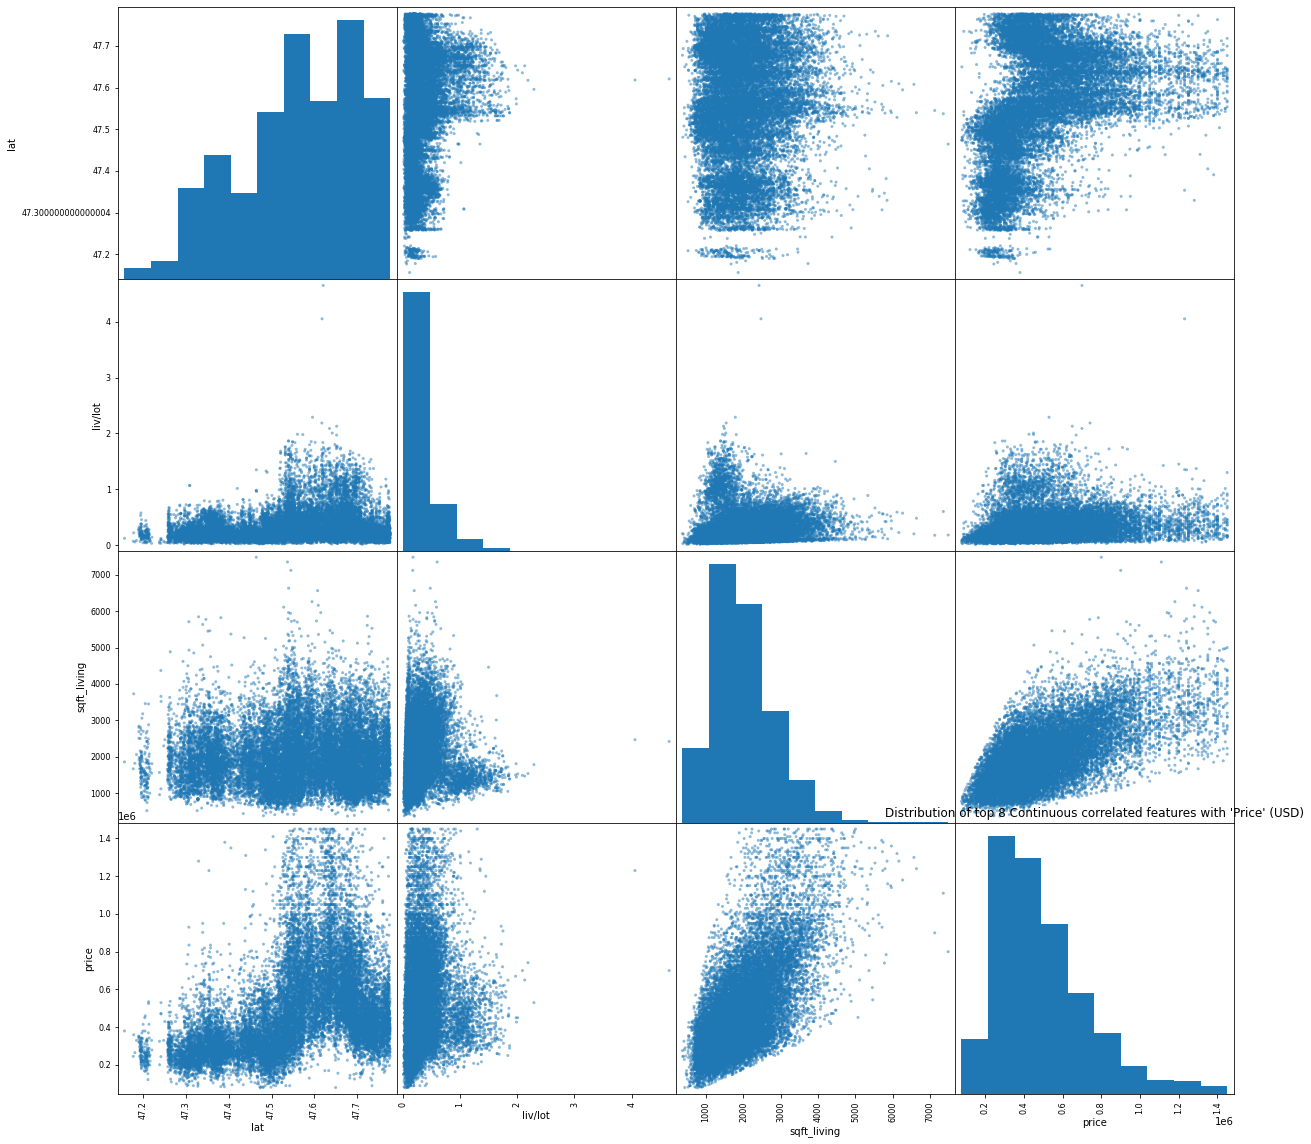

In [14]:
pd.plotting.scatter_matrix(df[top_8_cont+[target]], figsize=(20, 20));
plt.title("Distribution of top 8 Continuous correlated features with 'Price' (USD)")
plt.show()

#### Log transform and re-check distributions

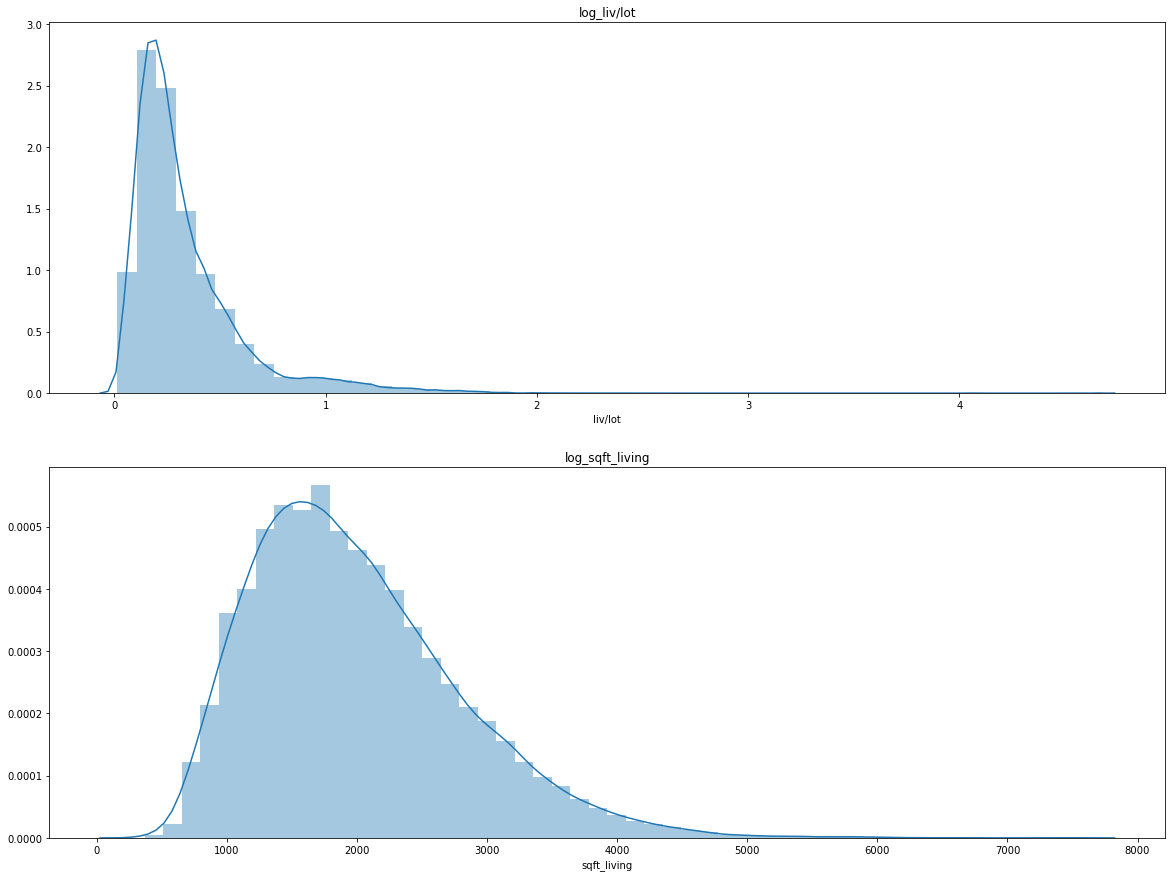

In [15]:
cols_to_log = list(set(top_8_cont) - {'lat'})
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,15))
for column, ax in zip(cols_to_log, axes.flatten()):
    df_8[column].map(lambda x: np.log(x))
    sns.distplot(df_8[column], label=f"log_{column}", ax=ax)
    df_8.rename({column: (f"log_"+column)}, axis=1, inplace=True)
    ax.set_title((f"log_"+column))

Should 'lat', 'zipcode_mean_liv', 'pop_density_by_zip' be moved to categorical?

#### Standardize Numerical Data

In [16]:
df_8_numeric_cols = ['log_liv/lot','lat','log_sqft_living','zipcode_mean_liv','pop_den_by_zip']

In [17]:
def norm_col(series):
    return (series - series.mean()) / series.std()

for column in df_8_numeric_cols:
    df_8[column] = norm_col(df_8[column])

df_8[df_8_numeric_cols]

,log_liv/lot,lat,log_sqft_living,zipcode_mean_liv,pop_den_by_zip
0,-0.466094,-0.357745,-1.019463,-0.806018,0.191979
1,0.078648,1.158754,0.717961,-0.768461,0.845172
2,-0.957956,1.280913,-1.531941,0.366546,-0.272392
3,0.217144,-0.288353,-0.044506,-0.875020,0.690154
4,-0.469559,0.405564,-0.394491,1.793358,-0.680425
...,...,...,...,...,...
20282,3.801331,1.001900,-0.581982,-1.054449,1.878399
20283,0.237233,-0.361359,0.392975,-1.104732,0.399239
20284,1.573380,0.243650,-1.219455,-0.581296,1.192085
20285,1.254279,-0.189325,-0.494486,1.189789,-1.343520


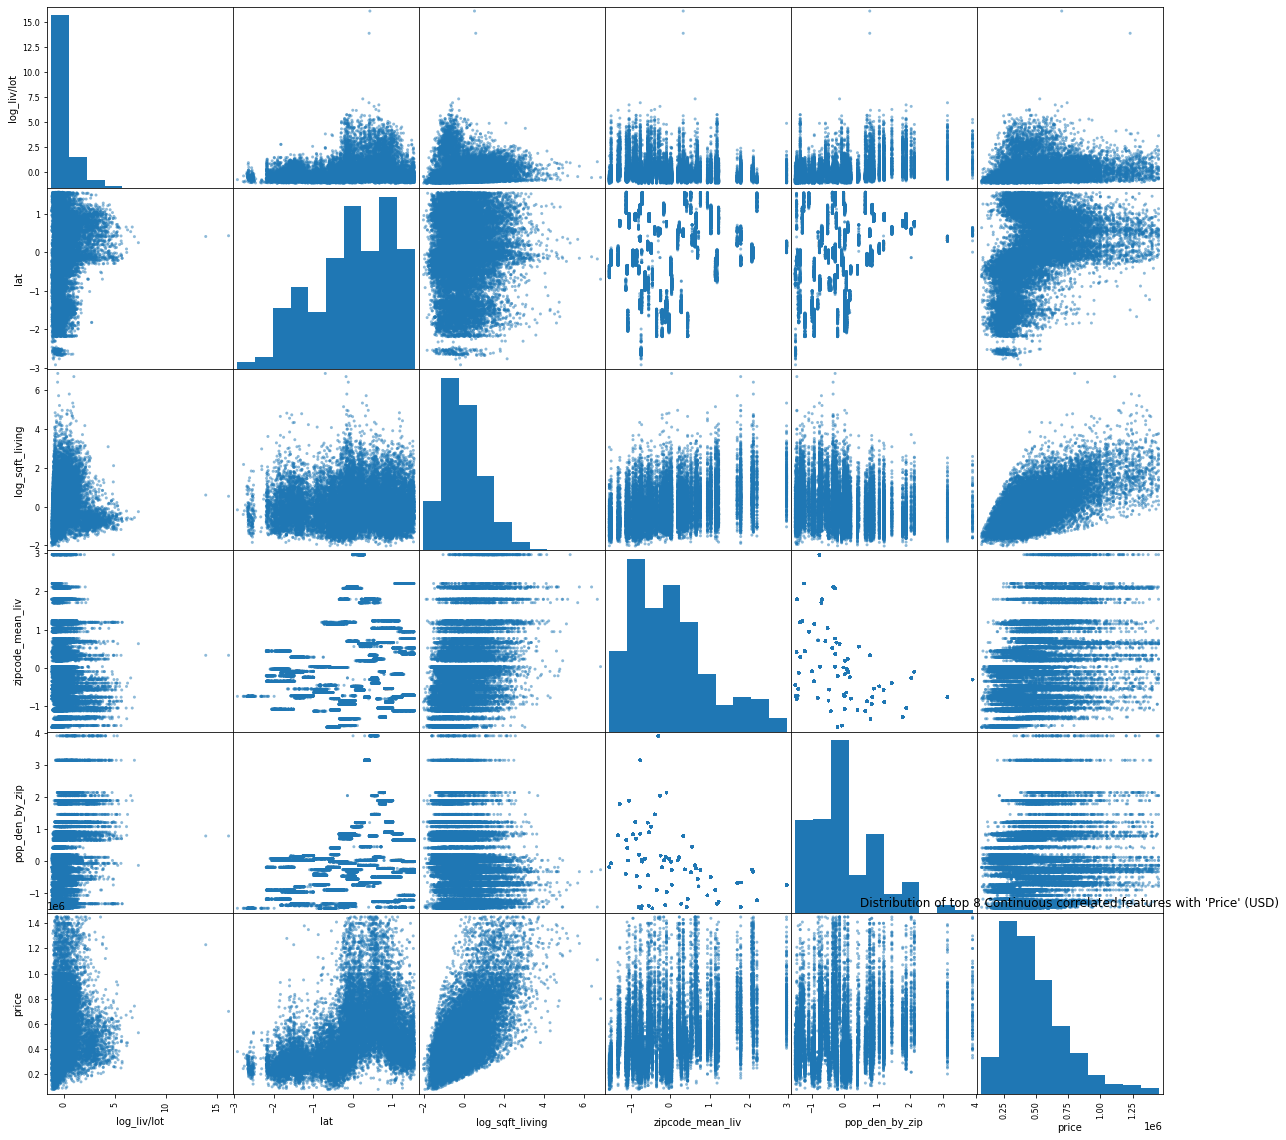

In [18]:
pd.plotting.scatter_matrix(df_8[df_8_numeric_cols+[target]], figsize=(20, 20));
plt.title("Distribution of top 8 Continuous correlated features with 'Price' (USD)")
plt.show()

Check multicolinearity again.

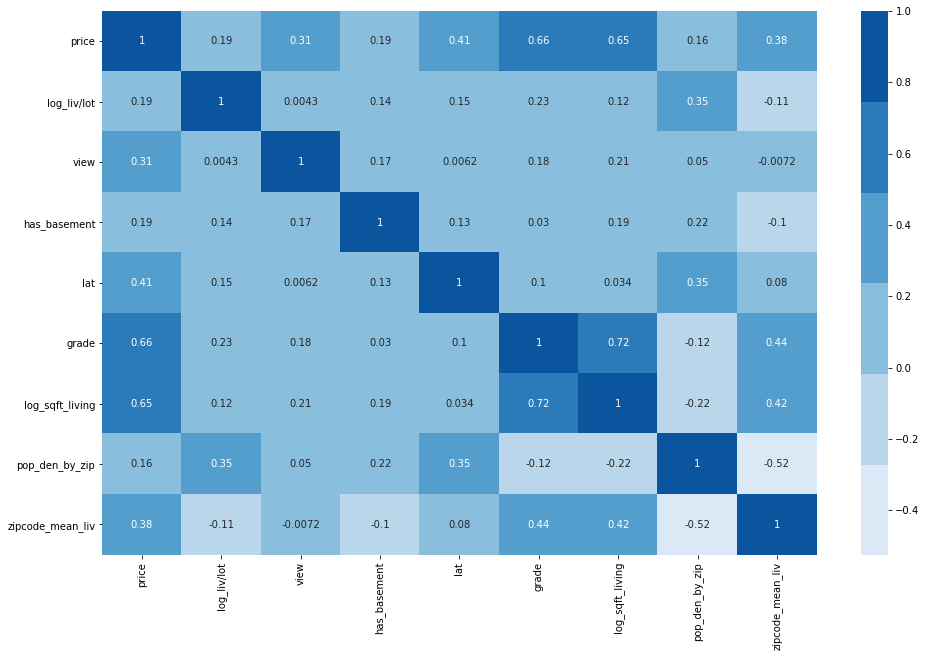

In [19]:
plt.figure(figsize=(16,10))
sns.heatmap(df_8.corr(), annot=True, cmap=sns.color_palette('Blues'), fmt='0.2g');

#### Encode Categorical Columns

In [20]:
top_8_cat = ['grade', # 13 cats, in ORDER, leave? then try dummied
 'has_basement', # bool, leave
 'zipcode_mean_liv', # dummy, all diff
 'view', 
 'pop_den_by_zip']

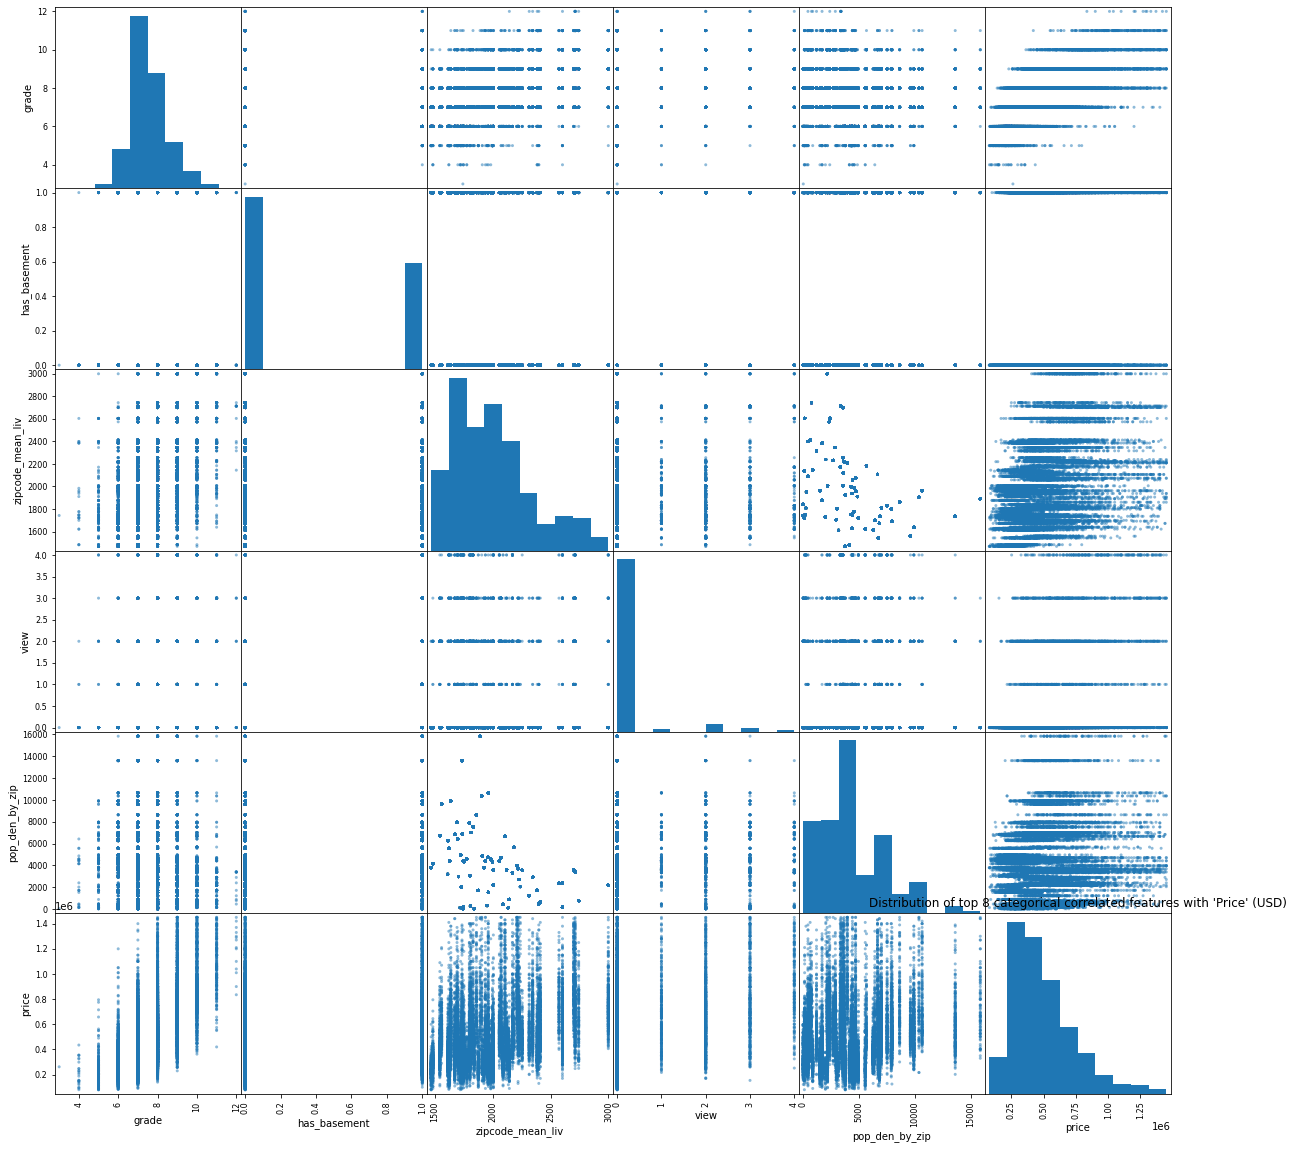

In [21]:
pd.plotting.scatter_matrix(df[top_8_cat+[target]], figsize=(20, 20));
plt.title("Distribution of top 8 categorical correlated features with 'Price' (USD)")
plt.show()

In [22]:
# make dummies
dum_cats = ['grade', 'view']
# get dummies, drop origin columns, concat with rest of df
df_8= pd.get_dummies(data=df_8, columns=dum_cats, prefix=dum_cats, drop_first=True)
df_8.head(3)

,price,log_liv/lot,has_basement,lat,log_sqft_living,pop_den_by_zip,zipcode_mean_liv,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,view_1.0,view_2.0,view_3.0,view_4.0
0,221900.0,-0.466094,0,-0.357745,-1.019463,0.191979,-0.806018,0,0,0,1,0,0,0,0,0,0,0,0,0
1,538000.0,0.078648,1,1.158754,0.717961,0.845172,-0.768461,0,0,0,1,0,0,0,0,0,0,0,0,0
2,180000.0,-0.957956,0,1.280913,-1.531941,-0.272392,0.366546,0,0,1,0,0,0,0,0,0,0,0,0,0


In [23]:
# # encode zip data
# from sklearn.preprocessing import LabelEncoder
# lb_make = LabelEncoder()
# df_8['encode_zip_mean_liv'] = lb_make.fit_transform(df_8['zipcode_mean_liv'])
# df_8['encode_pop_den_by_zip'] = lb_make.fit_transform(df_8['pop_den_by_zip'])

In [24]:
df_8.head()

,price,log_liv/lot,has_basement,lat,log_sqft_living,pop_den_by_zip,zipcode_mean_liv,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,view_1.0,view_2.0,view_3.0,view_4.0
0,221900.0,-0.466094,0,-0.357745,-1.019463,0.191979,-0.806018,0,0,0,1,0,0,0,0,0,0,0,0,0
1,538000.0,0.078648,1,1.158754,0.717961,0.845172,-0.768461,0,0,0,1,0,0,0,0,0,0,0,0,0
2,180000.0,-0.957956,0,1.280913,-1.531941,-0.272392,0.366546,0,0,1,0,0,0,0,0,0,0,0,0,0
3,604000.0,0.217144,1,-0.288353,-0.044506,0.690154,-0.875020,0,0,0,1,0,0,0,0,0,0,0,0,0
4,510000.0,-0.469559,0,0.405564,-0.394491,-0.680425,1.793358,0,0,0,0,1,0,0,0,0,0,0,0,0


In [25]:
#df_8.drop(['zipcode_mean_liv', 'pop_den_by_zip'], axis=1, inplace=True)

In [26]:
df_8_cols = list(df_8.columns)
df_8_cols

['price',
 'log_liv/lot',
 'has_basement',
 'lat',
 'log_sqft_living',
 'pop_den_by_zip',
 'zipcode_mean_liv',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12',
 'view_1.0',
 'view_2.0',
 'view_3.0',
 'view_4.0']

#### Grade

In [27]:
top_7_corr_grade_df = df_8.drop(['log_liv/lot','log_sqft_living'], axis=1)
top_7_corr_grade_features = list(top_7_corr_grade_df.drop('price', axis=1).columns)
top_7_corr_grade_features

['has_basement',
 'lat',
 'pop_den_by_zip',
 'zipcode_mean_liv',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12',
 'view_1.0',
 'view_2.0',
 'view_3.0',
 'view_4.0']

In [28]:
# trial 1
check_vif_feature_space(top_7_corr_grade_df, top_7_corr_grade_features)

True

In [29]:
model2 = build_sm_ols(top_7_corr_grade_df, top_7_corr_grade_features, target, add_constant=False, show_summary=True)

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.936
Model:                            OLS   Adj. R-squared (uncentered):              0.936
Method:                 Least Squares   F-statistic:                          1.735e+04
Date:                Tue, 13 Oct 2020   Prob (F-statistic):                        0.00
Time:                        15:21:13   Log-Likelihood:                     -2.6917e+05
No. Observations:               20287   AIC:                                  5.384e+05
Df Residuals:                   20270   BIC:                                  5.385e+05
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [31]:
# trial 2
# drop 'zip_mean_liv'
features2 = list(top_7_corr_grade_df[top_7_corr_grade_features].drop(['lat', 'zipcode_mean_liv', 'has_basement', 'view_1.0','view_2.0','view_3.0', 'view_4.0'],axis=1).columns)
check_vif_feature_space(top_7_corr_grade_df, features2)

True

In [32]:
model2 = build_sm_ols(top_7_corr_grade_df, features2, target, add_constant=False, show_summary=True)

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.905
Model:                            OLS   Adj. R-squared (uncentered):              0.905
Method:                 Least Squares   F-statistic:                          1.925e+04
Date:                Tue, 13 Oct 2020   Prob (F-statistic):                        0.00
Time:                        15:21:25   Log-Likelihood:                     -2.7316e+05
No. Observations:               20287   AIC:                                  5.463e+05
Df Residuals:                   20277   BIC:                                  5.464e+05
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [33]:
# trial 3
# drop 'encode_pop_den_by_zip'
features3 = list(top_7_corr_grade_df[top_7_corr_grade_features].drop(['pop_den_by_zip','zipcode_mean_liv'],axis=1).columns)
check_vif_feature_space(top_7_corr_grade_df, features3)

True

In [34]:
# build model
model1 = build_sm_ols(top_7_corr_grade_df, features3, target, add_constant=False, show_summary=True)

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.925
Model:                            OLS   Adj. R-squared (uncentered):              0.925
Method:                 Least Squares   F-statistic:                          1.678e+04
Date:                Tue, 13 Oct 2020   Prob (F-statistic):                        0.00
Time:                        15:21:26   Log-Likelihood:                     -2.7066e+05
No. Observations:               20287   AIC:                                  5.414e+05
Df Residuals:                   20272   BIC:                                  5.415e+05
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [35]:
# alarming rates of skew

False


Text(0.5, 1.0, 'QQ Plot for residuals MODEL 1')

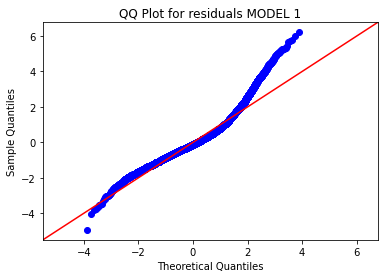

In [36]:
# Check residuals for normality
print(check_residuals_normal(model1))
resid1 = model1.resid
fig = sm.graphics.qqplot(resid1, dist=stats.norm, line='45', fit=True)
plt.title('QQ Plot for residuals MODEL 1')

In [37]:
# Check residuals for homoskedasticity
print(check_residuals_homoskedasticity(model1))

fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model1, target, fig=fig)
plt.show()

False


ValueError: 'price' is not in list

<Figure size 1080x576 with 0 Axes>

#### Sq. Ft Living

In [38]:
top_7_corr_sqliv = list(set(df_8_cols) - {'grade_4',
                                             'grade_5',
                                             'grade_6',
                                             'grade_7',
                                             'grade_8',
                                             'grade_9',
                                             'grade_10',
                                             'grade_11',
                                             'grade_12',})
top_7_corr_sqliv

['view_3.0',
 'log_liv/lot',
 'price',
 'has_basement',
 'lat',
 'view_2.0',
 'pop_den_by_zip',
 'zipcode_mean_liv',
 'view_1.0',
 'view_4.0',
 'log_sqft_living']

In [39]:
top_7_corr_sqliv_df = df_8[top_7_corr_sqliv]
check_vif_feature_space(top_7_corr_sqliv_df, top_7_corr_sqliv)

True

In [40]:
model4 = build_sm_ols(top_7_corr_sqliv_df, top_7_corr_sqliv, target, add_constant=False, show_summary=True)

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          5.706e+33
Date:                Tue, 13 Oct 2020   Prob (F-statistic):                        0.00
Time:                        15:21:35   Log-Likelihood:                      4.1515e+05
No. Observations:               20287   AIC:                                 -8.303e+05
Df Residuals:                   20276   BIC:                                 -8.302e+05
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [50]:
features5 = list(top_7_corr_sqliv_df.drop(['log_sqft_living', 'view_2.0'],axis=1).columns)
check_vif_feature_space(top_7_corr_sqliv_df, features5)

True

In [51]:
model5 = build_sm_ols(top_7_corr_sqliv_df, features5, target, add_constant=False, show_summary=True)

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.014e+34
Date:                Tue, 13 Oct 2020   Prob (F-statistic):                        0.00
Time:                        15:48:14   Log-Likelihood:                      4.1894e+05
No. Observations:               20287   AIC:                                 -8.379e+05
Df Residuals:                   20278   BIC:                                 -8.378e+05
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

### Check for Multicollinearity

In [46]:
df_corr=df[test].corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
df_corr.set_index(['pairs'], inplace = True)
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr.columns = ['cc']
# drop duplicates. This could be dangerous if you have variables perfectly correlated 
# with variables other than themselves.
df_corr.drop_duplicates(inplace=True)
# adjust new table as needed
df_corr[(abs(df_corr.cc)>.3) & (abs(df_corr.cc) <1)]

KeyError: "['zip_rank_price'] not in index"

In [ ]:
# check r2 score with OLS model

### Normalize Numerical Data

### Export transformed data

For use in linear regression modeling

(describe transformation logic/new features)

In [ ]:
#df.to_csv("./data/kc_house_data_transformed.csv")

## Build Model

### train/test

### cross validate model